In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import digamma
from sklearn.gaussian_process import GaussianProcessRegressor
import gpytorch

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

/Users/menang/anaconda3/envs/py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's consider a simpler setting where 
$f(x) = 4 sin(x), x \in [a,b]$, and $y_i$ is bags of each bin with 1/n width. So that $g(y) = E[sin(x)|y] = \frac{1}{max(y) - min(y)}\int_{min(y)}^{max(y)} 4 sin(x) dx = - 4 cos(max(y)) + 4 cos(min(y))$.

In [2]:
def func(x):
    return 4 * np.sin(x)

def ytox(y, a, b, n):
    xs = []
    for i in y:
        # Determine the bin index
        # Calculate bin width
        bin_width = (b - a) / n

        # Determine the bin index
        bin_index = int((i - a) // bin_width)

        # Calculate the lower and upper bounds of the detected bin
        lower_bound = a + bin_index * bin_width
        upper_bound = a + (bin_index + 1) * bin_width
        
        x = np.random.uniform(lower_bound, upper_bound)
        xs.append(x)
        
    return np.array(xs) 

def g(y, a=-4, b=4, n=20, sigma=0.1):
    # Calculate the bin width
   
    # Determine the bin index
    # Calculate bin width
    bin_width = (b - a) / n

    # Determine the bin index
    bin_index = int((y - a) // bin_width)

    # Calculate the lower and upper bounds of the detected bin
    lower_bound = a + bin_index * bin_width
    upper_bound = a + (bin_index + 1) * bin_width

    result = 1.0/(upper_bound - lower_bound) * (- 4 * np.cos(upper_bound) + 4 * np.cos(lower_bound)) + np.random.normal(0, sigma)
        
    return result

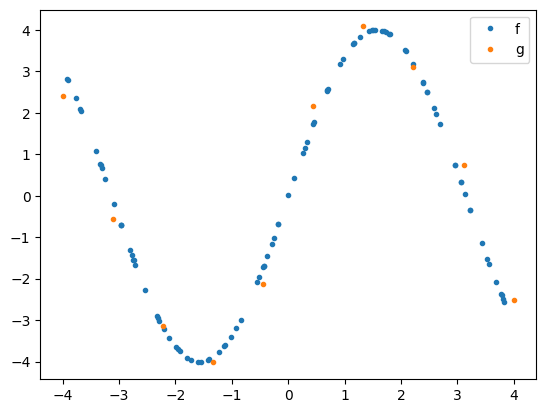

In [3]:
a = -4
b = 4
n = 20
sigma = 0.1

ys = np.linspace(a,b,100)
xs = ytox(ys, a, b, n)
fs = func(xs)
ys2 = np.linspace(a,b,10)
zs = np.array([g(y, a, b, n, sigma) for y in ys2])
plt.plot(xs, fs, '.', label= 'f')
plt.plot(ys2, zs, '.', label= 'g')
plt.legend()

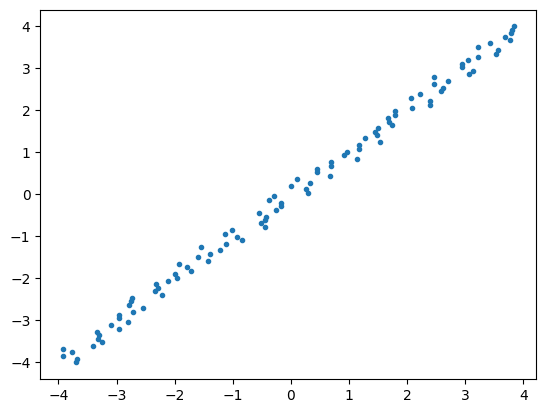

In [4]:
plt.plot(xs, ys, '.')

In [5]:
muz, sigmaz = zs.mean(), zs.std()
zs = (zs - muz) / sigmaz

In [6]:
import sys
# sys.path.append("../deconditional-downscaling/")
sys.path.append("experiments/swiss_roll/")
from models import build_model, train_model, predict 
import yaml 
import torch

cdf_dir = 'experiments/swiss_roll/config/exact_cmp.yaml' 
# cdf_dir = 'exact_cmp.yaml' 

with open(cdf_dir, "r") as f:
    cfg = yaml.safe_load(f)

cfg['model'].update(individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys2))
model = build_model(cfg['model'])

In [7]:
groundtruth_individuals = torch.tensor(np.linspace(a,b,100)).float()

cfg['training'].update(model=model,
                    individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys2),
                    groundtruth_individuals=groundtruth_individuals,
                    groundtruth_bags_sizes=len(groundtruth_individuals),
                    groundtruth_targets=func(groundtruth_individuals).float(),
                    chunk_size=cfg['evaluation']['chunk_size_nll'],
                    device_idx='cpu',
                    dump_dir='result/'
                    )
train_model(cfg['training'])

In [8]:
predict_kwargs = {'name': cfg['model']['name'],
                'model': model.eval().cpu(),
                'individuals': groundtruth_individuals,
                'bags_sizes': func(groundtruth_individuals)}
individuals_posterior = predict(predict_kwargs)
individuals_posterior_mean = sigmaz * individuals_posterior.mean + muz
with torch.no_grad():
    stddev = sigmaz * individuals_posterior.stddev
    lower_bound = individuals_posterior_mean - 2 * stddev
    upper_bound = individuals_posterior_mean + 2 * stddev

In [9]:
individuals_posterior.sample()

tensor([ 1.1645,  1.1393,  1.0989,  1.0480,  0.9616,  0.8514,  0.7000,  0.5354,
         0.3424,  0.1366, -0.0751, -0.2765, -0.4579, -0.6173, -0.7482, -0.8538,
        -0.9287, -0.9644, -0.9917, -0.9910, -0.9882, -0.9812, -0.9872, -1.0050,
        -1.0581, -1.1410, -1.2600, -1.4081, -1.5678, -1.7503, -1.9219, -2.0711,
        -2.1875, -2.2555, -2.2779, -2.2450, -2.1642, -2.0436, -1.8831, -1.7053,
        -1.5226, -1.3401, -1.1578, -0.9923, -0.8398, -0.6877, -0.5323, -0.3860,
        -0.2290, -0.0463,  0.1530,  0.3712,  0.6028,  0.8398,  1.0702,  1.2986,
         1.5013,  1.6826,  1.8378,  1.9547,  2.0357,  2.0904,  2.0998,  2.0904,
         2.0514,  1.9919,  1.9161,  1.8340,  1.7331,  1.6442,  1.5605,  1.4726,
         1.3982,  1.3381,  1.2706,  1.2188,  1.1632,  1.0999,  1.0199,  0.9287,
         0.8236,  0.7013,  0.5880,  0.4601,  0.3477,  0.2407,  0.1437,  0.0600,
        -0.0122, -0.0819, -0.1565, -0.2367, -0.3287, -0.4372, -0.5530, -0.6932,
        -0.8316, -0.9608, -1.0832, -1.17

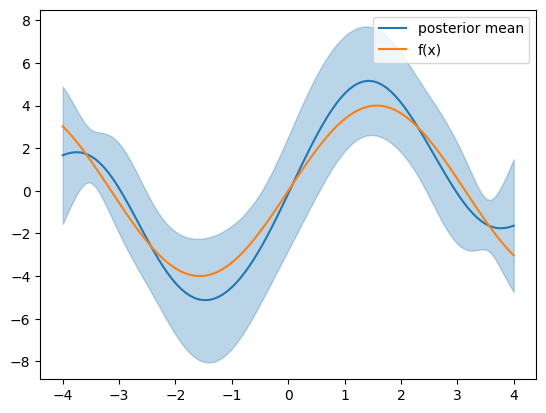

In [10]:
plt.plot(groundtruth_individuals, individuals_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(groundtruth_individuals, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(groundtruth_individuals, func(groundtruth_individuals), label = 'f(x)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [11]:
groundtruth_individuals[np.argmin(func(groundtruth_individuals))]

tensor(-1.5758)

In [12]:
groundtruth_individuals[np.argmin(individuals_posterior_mean)]

tensor(-1.4949)

In [13]:
from BO import BayesOpt_UCB, BayesOpt_Random, PES

x_space = torch.tensor(np.linspace(a,b,100)).float() # np.linspace(1e-5,1-1e-5,100)
y_space = torch.tensor(np.linspace(a,b,100)).float() # np.linspace(1e-5,1-1e-5,100)
init_y_size = 3
num_round = 20
num_repeat = 5
random_seeds = np.random.uniform(0,100, num_repeat)

pos_best_dict = {}

xs = torch.from_numpy(xs).float()
ys = torch.from_numpy(ys).float()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mengyan-zhang (oxmlgh). Use `wandb login --relogin` to force relogin


In [14]:
agent_pes = PES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/pes/',  y_min=-3, λ=0.01, num_opt_samples=10, random_seeds=random_seeds)
pos_best_dict['pes'] = agent_pes.simulation()

  0%|          | 0/5 [00:00<?, ?it/s]

[ 2.17056515 -3.83398441  1.06918588]


x_opt  tensor([-3.3535])
tensor([3.2115, 2.5982, 3.2771])
x_opt  tensor([-3.9192])
tensor([3.2115, 2.5982, 3.2771])
x_opt  tensor([-3.7576])
tensor([3.2115, 2.5982, 3.2771])
x_opt  tensor([-3.9192])
tensor([3.2115, 2.5982, 3.2771])
x_opt  tensor([-3.1919])
tensor([3.2115, 2.5982, 3.2771])
x_opt  tensor([-2.9495])
tensor([3.2115, 2.5982, 3.2771])
x_opt  tensor([-3.2727])
tensor([3.2115, 2.5982, 3.2771])
x_opt  tensor([-3.6768])
tensor([3.2115, 2.5982, 3.2771])
x_opt  tensor([-3.2727])
tensor([3.2115, 2.5982, 3.2771])
x_opt  tensor([-4.])
tensor([3.2115, 2.5982, 3.2771])


Iteration 1: Elapsed Time: 4.208161115646362 seconds
x_opt  tensor([3.7576])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237])
x_opt  tensor([3.4343])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237])
x_opt  tensor([3.2727])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237])
x_opt  tensor([4.])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237])
x_opt  tensor([4.])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237])
x_opt  tensor([-0.0404])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237])
x_opt  tensor([3.6768])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237])
x_opt  tensor([4.])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237])
x_opt  tensor([3.5152])


tensor([ 3.2115,  2.5982,  3.2771, -3.5237])
x_opt  tensor([3.7576])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237])
Iteration 2: Elapsed Time: 3.92558217048645 seconds
x_opt  tensor([4.])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086])
x_opt  tensor([0.2828])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086])
x_opt  tensor([-1.0101])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086])
x_opt  tensor([-1.9798])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086])
x_opt  tensor([-0.9293])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086])
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086])
x_opt  tensor([4.])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086])
x_opt  tensor([3.7576])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086])
x_opt  tensor([-1.0101])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086])


x_opt  tensor([-1.8990])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086])
Iteration 3: Elapsed Time: 3.4321157932281494 seconds
x_opt  tensor([-1.6566])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119])
x_opt  tensor([-1.4949])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119])
x_opt  tensor([-2.1414])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119])
x_opt  tensor([4.])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119])
x_opt  tensor([-2.0606])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119])
x_opt  tensor([-1.4949])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119])
x_opt  tensor([-1.4949])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119])
x_opt  tensor([-0.8485])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119])
x_opt  tensor([-1.5758])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119])


x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119])
Iteration 4: Elapsed Time: 3.7580888271331787 seconds
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369])
x_opt  tensor([-1.8182])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369])
x_opt  tensor([-0.2828])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369])
x_opt  tensor([-1.5758])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369])
x_opt  tensor([-0.6061])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369])
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369])
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369])
x_opt  tensor([-1.0909])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369])
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4

x_opt  tensor([-0.6061])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369])
Iteration 5: Elapsed Time: 3.8585948944091797 seconds
x_opt  tensor([-1.4141])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066])
x_opt  tensor([-1.8990])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066])
x_opt  tensor([-1.5758])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066])
x_opt  tensor([-2.1414])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066])
x_opt  tensor([-1.5758])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066])
x_opt  tensor([-1.4141])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066])
x_opt  tensor([-2.2222])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066])
x_opt  tensor([-1.5758])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066])
x

Iteration 6: Elapsed Time: 3.944905996322632 seconds
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680])
x_opt  tensor([-0.6869])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680])
x_opt  tensor([-2.0606])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680])
x_opt  tensor([-1.8990])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680])
x_opt  tensor([-2.1414])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680])
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680])
x_opt  tensor([-2.1414])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680])
x_opt  tensor([-1.6566])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119,


 41%|████      | 7/17 [00:27<00:38,  3.88s/it]

tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680])
x_opt  tensor([-1.4949])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680])
Iteration 7: Elapsed Time: 3.9306046962738037 seconds


x_opt  tensor([4.])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578])
x_opt  tensor([0.2020])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578])
x_opt  tensor([-1.4141])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578])
x_opt  tensor([-1.8990])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578])
x_opt  tensor([-1.7374])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578])
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578])
x_opt  tensor([4.])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578])
x_opt  tensor([-1.0101])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, 

Iteration 8: Elapsed Time: 4.181324005126953 seconds
x_opt  tensor([4.])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141])
x_opt  tensor([-1.5758])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141])
x_opt  tensor([-1.4141])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141])
x_opt  tensor([-1.0101])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141])
x_opt  tensor([-1.4141])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141])
x_opt  tensor([-1.4141])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141])
x_opt  tensor([-1.6566])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
 

Iteration 9: Elapsed Time: 3.58841609954834 seconds
x_opt  tensor([3.2727])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068])
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068])
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068])
x_opt  tensor([-2.0606])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068])
x_opt  tensor([-1.4949])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068])
x_opt  tensor([-1.0101])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068])
x_opt  tensor([-0.8485])
tensor([ 3.2115,  2.5982

Iteration 10: Elapsed Time: 3.6421687602996826 seconds
x_opt  tensor([-1.4141])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161])
x_opt  tensor([-2.1414])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161])
x_opt  tensor([-0.7677])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161])
x_opt  tensor([-1.1717])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161])
x_opt  tensor([-2.0606])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161])
x_opt  tensor([-1.1717])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -

tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161])
Iteration 11: Elapsed Time: 3.8559632301330566 seconds
x_opt  tensor([-1.0909])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865])
x_opt  tensor([-1.9798])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865])
x_opt  tensor([-1.1717])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865])
x_opt  tensor([4.])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865])
x_opt  tensor([-1.4141])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5

Iteration 12: Elapsed Time: 3.753432035446167 seconds
x_opt  tensor([-1.3333])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277])
x_opt  tensor([-1.6566])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277])
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277])
x_opt  tensor([-1.2525])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277])
x_opt  tensor([-1.7374])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277])
x_opt  tensor([-1.7374])
tensor([ 3.2115,  2.5982,  3.2771, -

Iteration 13: Elapsed Time: 3.8675060272216797 seconds
x_opt  tensor([-1.4141])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095])
x_opt  tensor([-0.6869])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095])
x_opt  tensor([-1.7374])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095])
x_opt  tensor([-1.1717])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095])
x_opt  tensor([-1.3333])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095])
x_opt  tensor([

Iteration 14: Elapsed Time: 3.992626905441284 seconds
x_opt  tensor([-1.1717])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961])
x_opt  tensor([-0.3636])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961])
x_opt  tensor([-1.6566])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961])
x_opt  tensor([-1.1717])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961])
x_opt  tensor([-1.4141])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.

Iteration 15: Elapsed Time: 3.8920252323150635 seconds
x_opt  tensor([-1.9798])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961,  2.3322])
x_opt  tensor([-1.5758])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961,  2.3322])
x_opt  tensor([-1.7374])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961,  2.3322])
x_opt  tensor([-2.0606])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961,  2.3322])
x_opt  tensor([-1.4949])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -

Iteration 16: Elapsed Time: 3.9167542457580566 seconds
x_opt  tensor([-1.8990])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961,  2.3322, -3.5265])
x_opt  tensor([-1.6566])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961,  2.3322, -3.5265])
x_opt  tensor([-1.5758])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961,  2.3322, -3.5265])
x_opt  tensor([-1.3333])
tensor([ 3.2115,  2.5982,  3.2771, -3.5237, -3.4086, -3.4119, -3.4369, -2.1066,
         2.5680, -3.4578, -3.3141,  2.5068, -3.4161, -3.4865, -3.4277,  2.6095,
         2.3961,  2.3322, -3.5265])
x_opt  tensor([-1.3333])
tensor([ 3.2115,  2.5982,  3.2771, -

100%|██████████| 17/17 [01:05<00:00,  3.87s/it]

Iteration 17: Elapsed Time: 4.0696861743927 seconds



 20%|██        | 1/5 [01:06<04:24, 66.13s/it]

[-0.00244544 -1.95250293 -1.93519495]


x_opt  tensor([4.])
tensor([-0.7752, -3.9585, -3.9635])
x_opt  tensor([3.6768])
tensor([-0.7752, -3.9585, -3.9635])
x_opt  tensor([-1.8990])
tensor([-0.7752, -3.9585, -3.9635])
x_opt  tensor([1.8182])
tensor([-0.7752, -3.9585, -3.9635])
x_opt  tensor([-2.7071])
tensor([-0.7752, -3.9585, -3.9635])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635])
x_opt  tensor([-4.])
tensor([-0.7752, -3.9585, -3.9635])
x_opt  tensor([-3.0303])
tensor([-0.7752, -3.9585, -3.9635])


x_opt  tensor([4.])
tensor([-0.7752, -3.9585, -3.9635])
x_opt  tensor([3.7576])
tensor([-0.7752, -3.9585, -3.9635])
Iteration 1: Elapsed Time: 3.444074869155884 seconds
x_opt  tensor([-2.2222])
tensor([-0.7752, -3.9585, -3.9635,  2.4265])
x_opt  tensor([-1.2525])
tensor([-0.7752, -3.9585, -3.9635,  2.4265])
x_opt  tensor([-1.7374])
tensor([-0.7752, -3.9585, -3.9635,  2.4265])
x_opt  tensor([-2.1414])
tensor([-0.7752, -3.9585, -3.9635,  2.4265])
x_opt  tensor([-2.4646])
tensor([-0.7752, -3.9585, -3.9635,  2.4265])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265])
x_opt  tensor([2.1414])
tensor([-0.7752, -3.9585, -3.9635,  2.4265])
x_opt  tensor([-2.3030])
tensor([-0.7752, -3.9585, -3.9635,  2.4265])
x_opt  tensor([-2.0606])
tensor([-0.7752, -3.9585, -3.9635,  2.4265])
x_opt  tensor([-1.7374])
tensor([-0.7752, -3.9585, -3.9635,  2.4265])


Iteration 2: Elapsed Time: 3.488016128540039 seconds
x_opt  tensor([-1.5758])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823])
x_opt  tensor([-2.0606])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823])
x_opt  tensor([-2.0606])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823])
x_opt  tensor([-2.2222])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823])
x_opt  tensor([-1.8990])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823])
x_opt  tensor([-2.1414])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823])
x_opt  tensor([-1.6566])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823])


x_opt  tensor([-1.8990])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823])
Iteration 3: Elapsed Time: 3.469568967819214 seconds
x_opt  tensor([-2.2222])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533])
x_opt  tensor([-1.9798])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533])
x_opt  tensor([-2.4646])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533])
x_opt  tensor([-2.3838])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533])
x_opt  tensor([-2.3030])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533])
x_opt  tensor([-1.1717])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533])
x_opt  tensor([-2.3030])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533])
x_opt  tensor([-1.8990])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533])


x_opt  tensor([-2.3838])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533])
Iteration 4: Elapsed Time: 3.5517163276672363 seconds
x_opt  tensor([-1.4949])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421])
x_opt  tensor([-1.4949])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421])
x_opt  tensor([-2.0606])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421])
x_opt  tensor([-2.0606])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421])
x_opt  tensor([-1.9798])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421])
x_opt  tensor([-1.0101])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421])
x_opt  tensor([-1.9798])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421])
x_opt  tensor([-2.0606])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8

x_opt  tensor([4.])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421])
Iteration 5: Elapsed Time: 3.5815749168395996 seconds
x_opt  tensor([-1.6566])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292])
x_opt  tensor([-1.9798])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292])
x_opt  tensor([-2.0606])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292])
x_opt  tensor([4.])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292])
x_opt  tensor([-1.8990])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292])
x_opt  tensor([-1.8990])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292])
x_opt  tensor([-2.1414])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292])
x_opt  tensor([-1.9798])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292])
x_opt  tens

x_opt  tensor([-1.3333])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292])
Iteration 6: Elapsed Time: 3.5454208850860596 seconds
x_opt  tensor([-1.7374])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876])
x_opt  tensor([-1.4949])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876])
x_opt  tensor([-2.0606])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876])
x_opt  tensor([-2.1414])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876])
x_opt  tensor([-2.2222])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876])
x_opt  tensor([-1.6566])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.529

x_opt  tensor([-1.9798])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876])
Iteration 7: Elapsed Time: 3.64694881439209 seconds
x_opt  tensor([-1.7374])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133])
x_opt  tensor([-1.5758])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133])
x_opt  tensor([-1.4949])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133])
x_opt  tensor([-1.1717])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133])
x_opt  tensor([-1.5758])
tensor([

Iteration 8: Elapsed Time: 3.7501988410949707 seconds
x_opt  tensor([4.])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019])
x_opt  tensor([-1.8990])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019])
x_opt  tensor([-2.1414])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019])
x_opt  tensor([-1.3333])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019])
x_opt  tensor([-2.3030])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019])
x_opt  tensor([-1.7374])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019])
x_opt  tensor([-1.7374])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,


Iteration 9: Elapsed Time: 3.640610933303833 seconds
x_opt  tensor([-1.2525])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339])
x_opt  tensor([-1.9798])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339])
x_opt  tensor([-0.9293])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339])
x_opt  tensor([4.])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339])
x_opt  tensor([-0.8485])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339])
x_opt  tensor([-1.2525])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -

Iteration 10: Elapsed Time: 3.7555739879608154 seconds
x_opt  tensor([-1.4949])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505])
x_opt  tensor([-1.7374])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505])
x_opt  tensor([-1.6566])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505])
x_opt  tensor([-1.8990])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505])
x_opt  tensor([-1.6566])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  

Iteration 11: Elapsed Time: 3.748661994934082 seconds
x_opt  tensor([-0.6869])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100])
x_opt  tensor([-1.9798])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100])
x_opt  tensor([-0.8485])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100])
x_opt  tensor([-1.2525])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100])
x_opt  tensor([-1.8990])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100])
x_opt  tensor([-0.6061])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
 

tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100])
Iteration 12: Elapsed Time: 3.714790105819702 seconds
x_opt  tensor([-1.5758])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541])
x_opt  tensor([-1.4141])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541])
x_opt  tensor([-1.1717])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541])
x_opt  tensor([-0.6869])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541])
x_opt  tensor([-1.4141])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,

Iteration 13: Elapsed Time: 3.7969038486480713 seconds
x_opt  tensor([-1.2525])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325])
x_opt  tensor([-1.0101])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325])
x_opt  tensor([-1.0909])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325])
x_opt  tensor([-1.6566])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325])
x_opt  tensor([-1.0909])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325])
x_opt  tensor([

Iteration 14: Elapsed Time: 3.7895779609680176 seconds
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307])
x_opt  tensor([-0.3636])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307])
x_opt  tensor([-1.7374])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307])
x_opt  tensor([-0.6869])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307])
x_opt  tensor([-1.1717])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2

Iteration 15: Elapsed Time: 3.839444875717163 seconds
x_opt  tensor([-0.5253])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307,  2.3577])
x_opt  tensor([-0.6869])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307,  2.3577])
x_opt  tensor([-0.6869])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307,  2.3577])
x_opt  tensor([-1.0909])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307,  2.3577])
x_opt  tensor([-1.4949])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0

Iteration 16: Elapsed Time: 4.007538795471191 seconds
x_opt  tensor([-0.5253])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307,  2.3577,  2.3742])
x_opt  tensor([-1.2525])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307,  2.3577,  2.3742])
x_opt  tensor([-1.3333])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307,  2.3577,  2.3742])
x_opt  tensor([-1.8182])
tensor([-0.7752, -3.9585, -3.9635,  2.4265, -3.3823,  3.8533, -0.6421,  0.5292,
        -2.4876, -3.3133,  2.6019,  2.3339,  2.4505,  2.4100,  2.4541,  2.3325,
         2.4307,  2.3577,  2.3742])
x_opt  tensor([-1.0909])
tensor([-0.7752, -3.9585, -3.9635,  2

100%|██████████| 17/17 [01:02<00:00,  3.69s/it]

Iteration 17: Elapsed Time: 3.989565849304199 seconds



 40%|████      | 2/5 [02:09<03:13, 64.34s/it]

[-2.76569937 -2.93040351 -1.09851627]


x_opt  tensor([0.6061])
tensor([-2.1496, -0.5013, -3.2605])
x_opt  tensor([3.2727])
tensor([-2.1496, -0.5013, -3.2605])
x_opt  tensor([-3.7576])
tensor([-2.1496, -0.5013, -3.2605])
x_opt  tensor([1.7374])
tensor([-2.1496, -0.5013, -3.2605])
x_opt  tensor([-2.8687])
tensor([-2.1496, -0.5013, -3.2605])
x_opt  tensor([1.0101])
tensor([-2.1496, -0.5013, -3.2605])
x_opt  tensor([4.])
tensor([-2.1496, -0.5013, -3.2605])
x_opt  tensor([-1.4949])
tensor([-2.1496, -0.5013, -3.2605])


x_opt  tensor([-1.4949])
tensor([-2.1496, -0.5013, -3.2605])
x_opt  tensor([0.4444])
tensor([-2.1496, -0.5013, -3.2605])
Iteration 1: Elapsed Time: 3.332334280014038 seconds
x_opt  tensor([-2.7071])
tensor([-2.1496, -0.5013, -3.2605, -3.2924])
x_opt  tensor([-2.3838])
tensor([-2.1496, -0.5013, -3.2605, -3.2924])
x_opt  tensor([0.3636])
tensor([-2.1496, -0.5013, -3.2605, -3.2924])
x_opt  tensor([3.9192])
tensor([-2.1496, -0.5013, -3.2605, -3.2924])
x_opt  tensor([3.5152])
tensor([-2.1496, -0.5013, -3.2605, -3.2924])
x_opt  tensor([4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924])
x_opt  tensor([-3.0303])
tensor([-2.1496, -0.5013, -3.2605, -3.2924])
x_opt  tensor([0.8485])
tensor([-2.1496, -0.5013, -3.2605, -3.2924])
x_opt  tensor([4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924])
x_opt  tensor([-3.4343])
tensor([-2.1496, -0.5013, -3.2605, -3.2924])


Iteration 2: Elapsed Time: 3.3793461322784424 seconds
x_opt  tensor([-1.4141])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333])
x_opt  tensor([1.0909])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333])
x_opt  tensor([-2.9495])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333])
x_opt  tensor([-0.2020])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333])
x_opt  tensor([-1.4141])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333])
x_opt  tensor([4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333])
x_opt  tensor([-4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333])
x_opt  tensor([-0.3636])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333])
x_opt  tensor([-2.3030])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333])
x_opt  tensor([-4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333])


Iteration 3: Elapsed Time: 3.423081874847412 seconds
x_opt  tensor([1.7374])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805])
x_opt  tensor([-3.9192])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805])
x_opt  tensor([-2.0606])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805])
x_opt  tensor([4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805])
x_opt  tensor([3.1111])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805])
x_opt  tensor([-0.7677])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805])
x_opt  tensor([-1.0101])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805])
x_opt  tensor([1.2525])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805])
x_opt  tensor([-4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805])


x_opt  tensor([0.3636])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805])
Iteration 4: Elapsed Time: 3.4673478603363037 seconds
x_opt  tensor([2.8687])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760])
x_opt  tensor([-2.8687])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760])
x_opt  tensor([-0.4444])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760])
x_opt  tensor([-1.4949])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760])
x_opt  tensor([-3.5152])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760])
x_opt  tensor([2.7879])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760])
x_opt  tensor([3.1919])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760])
x_opt  tensor([3.8384])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760])
x_opt  tensor([-1.0909])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, 

x_opt  tensor([0.7677])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760])
Iteration 5: Elapsed Time: 3.4962072372436523 seconds
x_opt  tensor([-0.7677])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192])
x_opt  tensor([-3.0303])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192])
x_opt  tensor([-4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192])
x_opt  tensor([3.6768])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192])
x_opt  tensor([0.6869])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192])
x_opt  tensor([3.2727])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192])
x_opt  tensor([-1.5758])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192])
x_opt  tensor([-3.7576])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192])
x_opt  te

x_opt  tensor([-4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192])
Iteration 6: Elapsed Time: 3.480701208114624 seconds
x_opt  tensor([-1.8990])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622])
x_opt  tensor([-1.8990])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622])
x_opt  tensor([3.7576])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622])
x_opt  tensor([-1.8990])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622])
x_opt  tensor([4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622])
x_opt  tensor([3.8384])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622])
x_opt  tensor([-0.2828])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         

tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622])
x_opt  tensor([-0.6869])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622])
Iteration 7: Elapsed Time: 3.620405912399292 seconds
x_opt  tensor([-1.4141])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563])
x_opt  tensor([-2.0606])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563])
x_opt  tensor([-1.6566])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563])
x_opt  tensor([-2.0606])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563])
x_opt  tensor([-1.3333])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563])
x_opt  tensor([4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0

x_opt  tensor([-1.4949])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563])
Iteration 8: Elapsed Time: 3.519036054611206 seconds
x_opt  tensor([-0.5253])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598])
x_opt  tensor([-1.8182])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598])
x_opt  tensor([-1.1717])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598])
x_opt  tensor([-1.2525])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598])
x_opt  tensor([-0.6061])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598])
x_opt  tensor([-0.9293])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
     

x_opt  tensor([-1.0101])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598])
Iteration 9: Elapsed Time: 3.9294910430908203 seconds
x_opt  tensor([-2.2222])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236])
x_opt  tensor([-1.8182])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236])
x_opt  tensor([-2.2222])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236])
x_opt  tensor([-1.4949])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236])
x_opt  tensor([-1.4141])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236])
x_opt  tensor([-0.7677])
tensor([-2.1496, -0.5013, -3.2

Iteration 10: Elapsed Time: 3.6559712886810303 seconds
x_opt  tensor([-1.6566])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338])
x_opt  tensor([-2.0606])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338])
x_opt  tensor([-1.5758])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338])
x_opt  tensor([-1.4141])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338])
x_opt  tensor([4.])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338])
x_opt  tensor([-1.8182])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.633

Iteration 11: Elapsed Time: 3.7794382572174072 seconds
x_opt  tensor([-1.4141])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794])
x_opt  tensor([-1.2525])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794])
x_opt  tensor([-1.3333])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794])
x_opt  tensor([-1.0909])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794])
x_opt  tensor([-0.7677])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794])
x_opt  tensor([-1.4141])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,


Iteration 12: Elapsed Time: 3.774679660797119 seconds
x_opt  tensor([-1.8182])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049])
x_opt  tensor([-1.1717])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049])
x_opt  tensor([-1.7374])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049])
x_opt  tensor([-1.3333])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049])
x_opt  tensor([-1.0909])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049])
x_opt  tensor([-1.4949])
tensor([-2.1496, -0.5013, -3.2605, -

x_opt  tensor([-1.7374])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049])
Iteration 13: Elapsed Time: 3.8170669078826904 seconds
x_opt  tensor([-1.7374])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608])
x_opt  tensor([-1.3333])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608])
x_opt  tensor([-0.6869])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608])
x_opt  tensor([-1.8182])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608])
x_opt  tensor([-1.2525])

Iteration 14: Elapsed Time: 3.7555079460144043 seconds
x_opt  tensor([-1.2525])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448])
x_opt  tensor([-1.4949])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448])
x_opt  tensor([-0.9293])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448])
x_opt  tensor([-2.0606])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448])
x_opt  tensor([-1.8182])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3

Iteration 15: Elapsed Time: 3.906597137451172 seconds
x_opt  tensor([-1.2525])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448,  2.4018])
x_opt  tensor([-1.1717])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448,  2.4018])
x_opt  tensor([-1.2525])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448,  2.4018])
x_opt  tensor([-0.8485])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448,  2.4018])
x_opt  tensor([-1.8182])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3

Iteration 16: Elapsed Time: 3.877079963684082 seconds
x_opt  tensor([-1.4949])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448,  2.4018,  2.5008])
x_opt  tensor([-1.9798])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448,  2.4018,  2.5008])
x_opt  tensor([-0.6869])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448,  2.4018,  2.5008])
x_opt  tensor([-0.7677])
tensor([-2.1496, -0.5013, -3.2605, -3.2924,  0.6333, -3.1805, -0.8760, -3.2192,
         0.9622,  3.9563, -3.4598,  2.5236,  2.6338,  2.4794, -3.6049,  2.5608,
         2.3448,  2.4018,  2.5008])
x_opt  tensor([-1.3333])
tensor([-2.1496, -0.5013, -3.2605, -3

100%|██████████| 17/17 [01:02<00:00,  3.66s/it]

Iteration 17: Elapsed Time: 3.9444990158081055 seconds



 60%|██████    | 3/5 [03:11<02:06, 63.48s/it]

[-3.91700677  0.01499674 -0.03381365]


x_opt  tensor([-0.6869])
tensor([ 2.3905,  0.6489, -0.8179])
x_opt  tensor([0.7677])
tensor([ 2.3905,  0.6489, -0.8179])
x_opt  tensor([0.9293])
tensor([ 2.3905,  0.6489, -0.8179])
x_opt  tensor([-0.4444])
tensor([ 2.3905,  0.6489, -0.8179])
x_opt  tensor([-1.0101])
tensor([ 2.3905,  0.6489, -0.8179])
x_opt  tensor([1.8182])
tensor([ 2.3905,  0.6489, -0.8179])
x_opt  tensor([0.7677])
tensor([ 2.3905,  0.6489, -0.8179])
x_opt  tensor([2.6263])
tensor([ 2.3905,  0.6489, -0.8179])


x_opt  tensor([-0.2828])
tensor([ 2.3905,  0.6489, -0.8179])
x_opt  tensor([-1.4141])
tensor([ 2.3905,  0.6489, -0.8179])
Iteration 1: Elapsed Time: 3.300278902053833 seconds
x_opt  tensor([3.7576])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804])
x_opt  tensor([3.1111])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804])
x_opt  tensor([1.3333])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804])
x_opt  tensor([-1.6566])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804])
x_opt  tensor([4.])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804])
x_opt  tensor([-0.3636])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804])
x_opt  tensor([3.5152])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804])
x_opt  tensor([2.2222])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804])
x_opt  tensor([-0.3636])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804])
x_opt  tensor([3.1919])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804])


Iteration 2: Elapsed Time: 3.4563698768615723 seconds
x_opt  tensor([3.4343])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319])
x_opt  tensor([3.8384])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319])
x_opt  tensor([3.3535])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319])
x_opt  tensor([3.0303])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319])
x_opt  tensor([3.7576])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319])
x_opt  tensor([4.])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319])
x_opt  tensor([2.9495])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319])
x_opt  tensor([3.5152])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319])
x_opt  tensor([3.2727])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319])


x_opt  tensor([2.6263])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319])
Iteration 3: Elapsed Time: 3.599729299545288 seconds
x_opt  tensor([4.])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968])
x_opt  tensor([3.2727])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968])
x_opt  tensor([3.1919])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968])
x_opt  tensor([4.])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968])
x_opt  tensor([2.3838])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968])
x_opt  tensor([3.6768])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968])
x_opt  tensor([3.5960])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968])
x_opt  tensor([0.1212])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968])
x_opt  tensor([3.1919])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968])


x_opt  tensor([3.2727])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968])
Iteration 4: Elapsed Time: 3.4651389122009277 seconds
x_opt  tensor([3.9192])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726])
x_opt  tensor([3.3535])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726])
x_opt  tensor([2.5455])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726])
x_opt  tensor([3.5960])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726])
x_opt  tensor([3.1919])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726])
x_opt  tensor([4.])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726])
x_opt  tensor([3.4343])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726])
x_opt  tensor([3.6768])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726])
x_opt  tensor([3.7576])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726])

Iteration 5: Elapsed Time: 4.184399843215942 seconds
x_opt  tensor([-1.8182])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529])
x_opt  tensor([-1.0909])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529])
x_opt  tensor([-1.8182])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529])
x_opt  tensor([-1.7374])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529])
x_opt  tensor([-1.2525])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529])
x_opt  tensor([-1.6566])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529])
x_opt  tensor([-1.8990])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529])
x_opt  tensor([2.5455])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529])
x_opt  tensor([3.7576])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.85

x_opt  tensor([3.2727])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529])
Iteration 6: Elapsed Time: 3.6420600414276123 seconds
x_opt  tensor([-1.3333])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745])
x_opt  tensor([-1.1717])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745])
x_opt  tensor([-1.6566])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745])
x_opt  tensor([2.7071])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745])
x_opt  tensor([-1.5758])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745])
x_opt  tensor([-1.8990])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745])
x_opt  tensor([-1.3333])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,

x_opt  tensor([-1.4141])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745])
Iteration 7: Elapsed Time: 3.5884430408477783 seconds
x_opt  tensor([4.])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102])
x_opt  tensor([-1.7374])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102])
x_opt  tensor([-1.4949])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102])
x_opt  tensor([3.6768])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102])
x_opt  tensor([-1.3333])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102])
x_opt  tensor([-1.7374])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102])
x_opt  tensor([-1.8182])
tensor([ 2.3

x_opt  tensor([-1.0101])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102])
Iteration 8: Elapsed Time: 3.666801929473877 seconds
x_opt  tensor([-1.0101])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454])
x_opt  tensor([-1.8182])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454])
x_opt  tensor([-1.6566])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454])
x_opt  tensor([-1.6566])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454])
x_opt  tensor([-0.7677])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454])
x_opt  tensor([-1.4141])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
     

Iteration 9: Elapsed Time: 3.679621696472168 seconds
x_opt  tensor([-2.4646])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840])
x_opt  tensor([-1.7374])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840])
x_opt  tensor([-0.6061])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840])
x_opt  tensor([-1.8182])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840])
x_opt  tensor([-1.1717])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840])
x_opt  tensor([-0.6869])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840])
x_opt  tensor([-1.5758])
tensor([ 2.3905,  0.64

tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840])
x_opt  tensor([-1.4141])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840])
Iteration 10: Elapsed Time: 4.194367170333862 seconds
x_opt  tensor([-1.7374])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216])
x_opt  tensor([-1.9798])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216])
x_opt  tensor([-1.4141])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216])
x_opt  tensor([-2.0606])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216])
x_opt  tensor([-2.2222])
tensor([ 2

Iteration 11: Elapsed Time: 3.976114273071289 seconds
x_opt  tensor([-1.5758])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853])
x_opt  tensor([-0.7677])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853])
x_opt  tensor([4.])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853])
x_opt  tensor([-1.4141])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853])
x_opt  tensor([-1.4141])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853])
x_opt  tensor([-1.2525])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
      

Iteration 12: Elapsed Time: 3.7625699043273926 seconds
x_opt  tensor([-1.3333])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782])
x_opt  tensor([-1.0101])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782])
x_opt  tensor([-0.6061])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782])
x_opt  tensor([-1.4949])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782])
x_opt  tensor([-1.6566])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782])
x_opt  tensor([-1.3333])
tensor([ 2.3905,  0.6489, -0.8179, 

tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782])
Iteration 13: Elapsed Time: 4.329474210739136 seconds
x_opt  tensor([-2.3030])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257])
x_opt  tensor([3.9192])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257])
x_opt  tensor([-1.1717])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257])
x_opt  tensor([-1.5758])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257])
x_opt  tensor([-1.0909])
tensor([ 2.3905,  0.6489, 

x_opt  tensor([-0.7677])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257])
Iteration 14: Elapsed Time: 3.9088950157165527 seconds
x_opt  tensor([-1.0101])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393])
x_opt  tensor([-0.9293])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393])
x_opt  tensor([-1.8990])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393])
x_opt  tensor([-2.0606])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  

Iteration 15: Elapsed Time: 3.7464780807495117 seconds
x_opt  tensor([-1.1717])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393,  2.3030])
x_opt  tensor([-1.3333])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393,  2.3030])
x_opt  tensor([4.])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393,  2.3030])
x_opt  tensor([4.])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393,  2.3030])
x_opt  tensor([-0.6869])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
  

Iteration 16: Elapsed Time: 3.881861925125122 seconds
x_opt  tensor([-2.3030])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393,  2.3030,  2.4470])
x_opt  tensor([-1.0909])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393,  2.3030,  2.4470])
x_opt  tensor([-2.0606])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393,  2.3030,  2.4470])
x_opt  tensor([-0.9293])
tensor([ 2.3905,  0.6489, -0.8179, -3.4804, -2.5319,  2.1968, -3.3726, -3.8529,
        -2.3745,  3.4102,  2.3454,  2.5840,  2.5216,  2.4853, -1.9782,  2.4257,
         2.4393,  2.3030,  2.4470])
x_opt  tensor([-0.7677])
tensor([ 2.3905,  0.6489, -0.8179, -3

100%|██████████| 17/17 [01:04<00:00,  3.78s/it]

Iteration 17: Elapsed Time: 3.8150200843811035 seconds



 80%|████████  | 4/5 [04:16<01:03, 63.89s/it]

[-2.2508396  -3.74877824 -1.70299778]


x_opt  tensor([0.4444])
tensor([-3.2659,  2.3421, -3.8191])
x_opt  tensor([-1.0101])
tensor([-3.2659,  2.3421, -3.8191])
x_opt  tensor([-2.0606])
tensor([-3.2659,  2.3421, -3.8191])
x_opt  tensor([0.1212])
tensor([-3.2659,  2.3421, -3.8191])
x_opt  tensor([3.0303])
tensor([-3.2659,  2.3421, -3.8191])
x_opt  tensor([-1.8990])
tensor([-3.2659,  2.3421, -3.8191])
x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191])
x_opt  tensor([-1.8990])
tensor([-3.2659,  2.3421, -3.8191])


x_opt  tensor([3.1919])
tensor([-3.2659,  2.3421, -3.8191])
x_opt  tensor([-0.6869])
tensor([-3.2659,  2.3421, -3.8191])
Iteration 1: Elapsed Time: 3.3082821369171143 seconds
x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191, -0.8745])
x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191, -0.8745])
x_opt  tensor([3.5152])
tensor([-3.2659,  2.3421, -3.8191, -0.8745])
x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745])
x_opt  tensor([-2.2222])
tensor([-3.2659,  2.3421, -3.8191, -0.8745])
x_opt  tensor([-1.8990])
tensor([-3.2659,  2.3421, -3.8191, -0.8745])
x_opt  tensor([-2.1414])
tensor([-3.2659,  2.3421, -3.8191, -0.8745])
x_opt  tensor([2.6263])
tensor([-3.2659,  2.3421, -3.8191, -0.8745])
x_opt  tensor([2.6263])
tensor([-3.2659,  2.3421, -3.8191, -0.8745])


x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191, -0.8745])
Iteration 2: Elapsed Time: 3.3185160160064697 seconds
x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691])
x_opt  tensor([-2.0606])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691])
x_opt  tensor([3.9192])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691])
x_opt  tensor([-2.1414])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691])
x_opt  tensor([-1.9798])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691])
x_opt  tensor([0.6869])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691])
x_opt  tensor([-1.5758])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691])
x_opt  tensor([-2.7879])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691])
x_opt  tensor([0.8485])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691])


x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691])
Iteration 3: Elapsed Time: 3.300769090652466 seconds
x_opt  tensor([-1.6566])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753])
x_opt  tensor([-2.0606])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753])
x_opt  tensor([1.0909])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753])
x_opt  tensor([-1.9798])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753])
x_opt  tensor([-1.0101])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753])
x_opt  tensor([4.])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753])
x_opt  tensor([3.5960])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753])
x_opt  tensor([-1.3333])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753])
x_opt  tensor([-2.0606])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753])


x_opt  tensor([-2.2222])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753])
Iteration 4: Elapsed Time: 3.3165981769561768 seconds
x_opt  tensor([-0.8485])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399])
x_opt  tensor([-1.3333])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399])
x_opt  tensor([-1.0101])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399])
x_opt  tensor([-1.5758])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399])
x_opt  tensor([-2.4646])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399])
x_opt  tensor([-1.6566])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399])
x_opt  tensor([-1.8990])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399])
x_opt  tensor([-1.9798])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399])
x_opt  tensor([-2.1414])


tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399])
x_opt  tensor([-0.9293])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399])
Iteration 5: Elapsed Time: 3.4086852073669434 seconds
x_opt  tensor([-0.8485])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348])
x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348])
x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348])
x_opt  tensor([-2.2222])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348])
x_opt  tensor([-1.3333])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348])
x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348])
x_opt  tensor([-1.7374])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348])
x_opt  tensor([-1.6566])
tensor([-3

x_opt  tensor([-1.6566])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348])
Iteration 6: Elapsed Time: 3.504762887954712 seconds
x_opt  tensor([-0.9293])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194])
x_opt  tensor([-2.2222])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194])
x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194])
x_opt  tensor([-1.7374])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194])
x_opt  tensor([-1.6566])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194])
x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194])
x_opt  tensor([-0.9293])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348

Iteration 7: Elapsed Time: 3.583209991455078 seconds
x_opt  tensor([-0.6869])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329])
x_opt  tensor([-0.6869])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329])
x_opt  tensor([-1.9798])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329])
x_opt  tensor([-2.3030])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329])
x_opt  tensor([-0.6869])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329])
x_opt  tensor([-0.7677])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329])
x_opt  tensor([-0.6061])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329])
x_opt  tensor([-1.2525]

Iteration 8: Elapsed Time: 4.068356990814209 seconds
x_opt  tensor([-1.8990])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506])
x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506])
x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506])
x_opt  tensor([-1.0909])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506])
x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506])
x_opt  tensor([-0.6869])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506])
x_opt  tensor([-1.1717])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.63

Iteration 9: Elapsed Time: 3.6080949306488037 seconds
x_opt  tensor([-1.0101])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063])
x_opt  tensor([-1.3333])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063])
x_opt  tensor([-1.5758])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063])
x_opt  tensor([-0.7677])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063])
x_opt  tensor([-1.7374])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063])
x_opt  tensor([-1.5758])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063])
x_opt  tensor([-0.4444])
tensor([-3.2659,  2.3

Iteration 10: Elapsed Time: 3.6605379581451416 seconds
x_opt  tensor([-1.5758])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458])
x_opt  tensor([-0.9293])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458])
x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458])
x_opt  tensor([-1.4141])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458])
x_opt  tensor([-1.0909])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458])
x_opt  tensor([-1.6566])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  

x_opt  tensor([-1.3333])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458])
Iteration 11: Elapsed Time: 3.8142619132995605 seconds
x_opt  tensor([-0.5253])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175])
x_opt  tensor([-1.4949])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175])
x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175])
x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175])
x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         

Iteration 12: Elapsed Time: 3.7402408123016357 seconds
x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421])
x_opt  tensor([-1.7374])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421])
x_opt  tensor([-1.2525])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421])
x_opt  tensor([-1.4141])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421])
x_opt  tensor([-0.9293])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421])
x_opt  tensor([-0.6061])
tensor([-3.2659,  2.3421, -3.8191, 

tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421])
Iteration 13: Elapsed Time: 3.849640130996704 seconds
x_opt  tensor([-1.3333])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162])
x_opt  tensor([-1.1717])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162])
x_opt  tensor([-1.8990])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162])
x_opt  tensor([-0.5253])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162])
x_opt  tensor([-1.3333])
tensor([-3.2659,  2.3421,

Iteration 14: Elapsed Time: 3.7882080078125 seconds
x_opt  tensor([-1.8990])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203])
x_opt  tensor([-1.8990])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203])
x_opt  tensor([-1.5758])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203])
x_opt  tensor([-0.9293])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203])
x_opt  tensor([-1.1717])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.35

Iteration 15: Elapsed Time: 3.9017770290374756 seconds
x_opt  tensor([-1.0101])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203,  2.3347])
x_opt  tensor([-1.3333])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203,  2.3347])
x_opt  tensor([-1.7374])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203,  2.3347])
x_opt  tensor([-1.3333])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203,  2.3347])
x_opt  tensor([-1.4949])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -

Iteration 16: Elapsed Time: 3.9235808849334717 seconds
x_opt  tensor([-0.9293])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203,  2.3347, -3.4551])
x_opt  tensor([-1.8182])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203,  2.3347, -3.4551])
x_opt  tensor([-1.0101])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203,  2.3347, -3.4551])
x_opt  tensor([-1.8990])
tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203,  2.3347, -3.4551])
x_opt  tensor([-1.4949])
tensor([-3.2659,  2.3421, -3.8191, -

100%|██████████| 17/17 [01:02<00:00,  3.65s/it]

Iteration 17: Elapsed Time: 3.9921910762786865 seconds



100%|██████████| 5/5 [05:18<00:00, 63.72s/it]


<Figure size 640x480 with 0 Axes>

In [15]:
agent_pes.z_rewards

tensor([-3.2659,  2.3421, -3.8191, -0.8745,  0.5691, -2.2753,  3.8399, -0.6348,
         2.3194,  2.4329,  2.3506,  2.7063,  2.5458,  2.5175,  2.4421,  2.4162,
         2.4203,  2.3347, -3.4551,  2.3340])

(array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

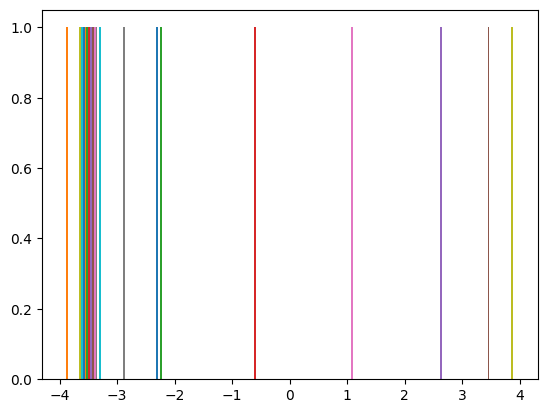

In [16]:
plt.hist(agent_pes.y_recs)

In [17]:
# agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/ucb/', random_seeds=random_seeds)
# pos_best_dict['ucb'] = agent_ucb.simulation()

In [18]:
agent_random = BayesOpt_Random(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/random/', random_seeds=random_seeds)
pos_best_dict['random']= agent_random.simulation()

  0%|          | 0/5 [00:00<?, ?it/s]

[ 2.17056515 -3.83398441  1.06918588]


Iteration 1: Elapsed Time: 2.858001947402954 seconds


Iteration 2: Elapsed Time: 2.751436710357666 seconds


Iteration 3: Elapsed Time: 2.7961602210998535 seconds


Iteration 4: Elapsed Time: 2.756845235824585 seconds


Iteration 5: Elapsed Time: 2.85029673576355 seconds


Iteration 6: Elapsed Time: 2.74377179145813 seconds


Iteration 7: Elapsed Time: 2.8437938690185547 seconds


Iteration 8: Elapsed Time: 2.7498490810394287 seconds


Iteration 9: Elapsed Time: 2.808321952819824 seconds


Iteration 10: Elapsed Time: 2.775485038757324 seconds


Iteration 11: Elapsed Time: 2.8116259574890137 seconds


Iteration 12: Elapsed Time: 2.7471840381622314 seconds


Iteration 13: Elapsed Time: 2.8101768493652344 seconds


Iteration 14: Elapsed Time: 2.8324642181396484 seconds


Iteration 15: Elapsed Time: 2.803589105606079 seconds


Iteration 16: Elapsed Time: 2.810523271560669 seconds


100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

Iteration 17: Elapsed Time: 2.711874008178711 seconds



 20%|██        | 1/5 [00:47<03:11, 47.78s/it]

[-0.00244544 -1.95250293 -1.93519495]


Iteration 1: Elapsed Time: 2.7669129371643066 seconds


Iteration 2: Elapsed Time: 2.7180299758911133 seconds


Iteration 3: Elapsed Time: 2.7191109657287598 seconds


Iteration 4: Elapsed Time: 2.706697940826416 seconds


Iteration 5: Elapsed Time: 2.7868478298187256 seconds


Iteration 6: Elapsed Time: 2.6956100463867188 seconds


Iteration 7: Elapsed Time: 2.7533888816833496 seconds


Iteration 8: Elapsed Time: 2.719635009765625 seconds


Iteration 9: Elapsed Time: 2.746131181716919 seconds


Iteration 10: Elapsed Time: 2.7902650833129883 seconds


Iteration 11: Elapsed Time: 2.6978330612182617 seconds


Iteration 12: Elapsed Time: 2.765048027038574 seconds


Iteration 13: Elapsed Time: 2.7215187549591064 seconds


Iteration 14: Elapsed Time: 2.7707040309906006 seconds


Iteration 15: Elapsed Time: 2.7414019107818604 seconds


Iteration 16: Elapsed Time: 2.8038439750671387 seconds


100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

Iteration 17: Elapsed Time: 2.7201240062713623 seconds



 40%|████      | 2/5 [01:34<02:21, 47.28s/it]

[-2.76569937 -2.93040351 -1.09851627]


Iteration 1: Elapsed Time: 2.7593510150909424 seconds


Iteration 2: Elapsed Time: 2.685861825942993 seconds


Iteration 3: Elapsed Time: 2.7640938758850098 seconds


Iteration 4: Elapsed Time: 2.6823177337646484 seconds


Iteration 5: Elapsed Time: 2.680361270904541 seconds


Iteration 6: Elapsed Time: 2.684739828109741 seconds


Iteration 7: Elapsed Time: 2.7598252296447754 seconds


Iteration 8: Elapsed Time: 2.789501905441284 seconds


Iteration 9: Elapsed Time: 2.6840858459472656 seconds


Iteration 10: Elapsed Time: 2.753119945526123 seconds


Iteration 11: Elapsed Time: 2.702887773513794 seconds


Iteration 12: Elapsed Time: 2.7227940559387207 seconds


Iteration 13: Elapsed Time: 2.6974477767944336 seconds


Iteration 14: Elapsed Time: 2.80662202835083 seconds


Iteration 15: Elapsed Time: 2.7567028999328613 seconds


Iteration 16: Elapsed Time: 2.797776937484741 seconds


100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

Iteration 17: Elapsed Time: 2.7253479957580566 seconds



 60%|██████    | 3/5 [02:21<01:34, 47.05s/it]

[-3.91700677  0.01499674 -0.03381365]


Iteration 1: Elapsed Time: 2.7541768550872803 seconds


Iteration 2: Elapsed Time: 2.660142183303833 seconds


Iteration 3: Elapsed Time: 2.765448808670044 seconds


Iteration 4: Elapsed Time: 2.654792070388794 seconds


Iteration 5: Elapsed Time: 2.7580440044403076 seconds


Iteration 6: Elapsed Time: 2.696382999420166 seconds


Iteration 7: Elapsed Time: 2.780869722366333 seconds


Iteration 8: Elapsed Time: 2.735413074493408 seconds


Iteration 9: Elapsed Time: 2.8216497898101807 seconds


Iteration 10: Elapsed Time: 2.723109006881714 seconds


Iteration 11: Elapsed Time: 2.7513279914855957 seconds


Iteration 12: Elapsed Time: 2.6818559169769287 seconds


Iteration 13: Elapsed Time: 2.743446111679077 seconds


Iteration 14: Elapsed Time: 2.767343759536743 seconds


Iteration 15: Elapsed Time: 2.7305750846862793 seconds


Iteration 16: Elapsed Time: 2.8095579147338867 seconds


100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

Iteration 17: Elapsed Time: 2.6983821392059326 seconds



 80%|████████  | 4/5 [03:08<00:46, 46.97s/it]

[-2.2508396  -3.74877824 -1.70299778]


Iteration 1: Elapsed Time: 2.7799439430236816 seconds


Iteration 2: Elapsed Time: 2.6775689125061035 seconds


Iteration 3: Elapsed Time: 2.740262031555176 seconds


Iteration 4: Elapsed Time: 2.6979827880859375 seconds


Iteration 5: Elapsed Time: 2.8420562744140625 seconds


Iteration 6: Elapsed Time: 2.7230119705200195 seconds


Iteration 7: Elapsed Time: 2.830996036529541 seconds


Iteration 8: Elapsed Time: 2.7247111797332764 seconds


Iteration 9: Elapsed Time: 2.730524778366089 seconds


Iteration 10: Elapsed Time: 2.6938347816467285 seconds


Iteration 11: Elapsed Time: 2.730199098587036 seconds


Iteration 12: Elapsed Time: 2.687798023223877 seconds


Iteration 13: Elapsed Time: 2.763237953186035 seconds


Iteration 14: Elapsed Time: 2.7145841121673584 seconds


Iteration 15: Elapsed Time: 2.76680588722229 seconds


Iteration 16: Elapsed Time: 2.6889162063598633 seconds


100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

Iteration 17: Elapsed Time: 2.7747678756713867 seconds



100%|██████████| 5/5 [03:55<00:00, 47.04s/it]


<Figure size 640x480 with 0 Axes>

(array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

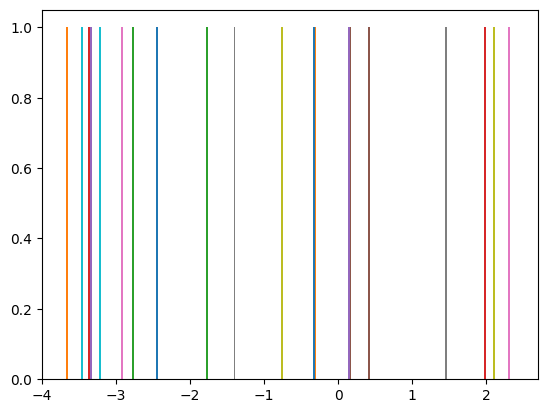

In [19]:
plt.hist(agent_random.y_recs)

In [1]:
def evalaution(pos_best_dict):
    # plt.plot(range(self.n), self.z_rewards[self.init_y_recs_size:], '.', label = 'z rewards')
    for name, pos_bests in pos_best_dict.items():
        opt = np.min(func(x_space.numpy()))
        regret_mean =np.abs(opt - pos_bests).mean(axis=0)
        regret_std =np.abs(opt - pos_bests).std(axis=0)
        # print(regret_mean)
        plt.plot(range(len(regret_mean)), regret_mean, label = name)
        plt.fill_between(range(len(regret_mean)), regret_mean - 2 * regret_std, regret_mean + 2 * regret_std, alpha = 0.3)
    # plt.ylim(0,2)
    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Regret')  

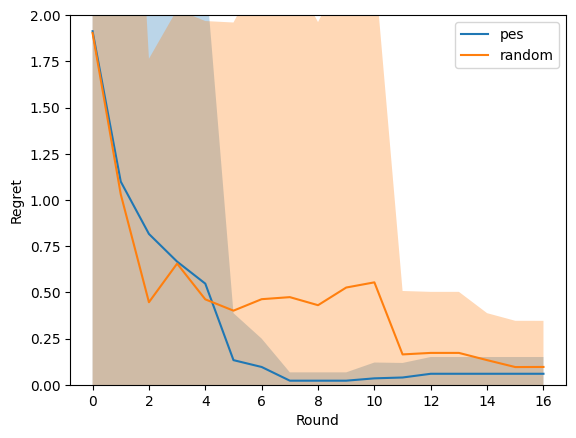

In [25]:
evalaution(pos_best_dict)

In [22]:
pos_best_dict['pes'][-1]


[tensor(-3.7865),
 tensor(-3.7865),
 tensor(-3.7865),
 tensor(-3.6701),
 tensor(-3.7865),
 tensor(-4.0000),
 tensor(-3.9885),
 tensor(-3.9510),
 tensor(-3.9510),
 tensor(-3.9510),
 tensor(-3.9510),
 tensor(-3.9510),
 tensor(-3.8878),
 tensor(-3.8878),
 tensor(-3.8878),
 tensor(-3.8878),
 tensor(-3.8878)]

In [23]:
# np.save('pos-seed24.npy', pos_best_dict)